In [1]:
import pandas as pd
import joblib
from sklearn.metrics import (
   f1_score, accuracy_score, precision_score,
    recall_score, roc_auc_score, confusion_matrix, roc_curve
)

import matplotlib.pyplot as plt
import json


In [2]:
def preprocess_test_data(test_data,drop_colum_list,scaler_file):
    """preprocessing the test data for model"""
    if 'ID' in test_data.columns:
        test_data = test_data.drop('ID', axis=1)
        
    test_data = test_data.drop(drop_colum_list, axis=1)
    
    scaler = joblib.load(scaler_file)
    test_target = test_data['target']
    test_features = test_data.drop(columns=['target'])
    test_features_scaled = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)
    
    test_data_scaled = test_features_scaled.copy()
    test_data_scaled['target'] = test_target.reset_index(drop=True)
    
    return test_data_scaled
    
    

In [3]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # For models without predict_proba
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    return y_pred

In [4]:
def main(test_data):
    
    #load columns that needs to be droped
    with open('colums_to_drop_list.json', 'r') as json_file:
        drop_colum_list = json.load(json_file)
    drop_colum_list = set(drop_colum_list)
    
    scaler_file = "scaler.pkl"
    
    test_data = preprocess_test_data(test_data,drop_colum_list,scaler_file)
    
    model = joblib.load("best_model.pkl")
    
    y_test = test_data['target']
    X_test = test_data.drop(columns=['target'])
    
    model_name = 'XGBoost'
    
    y_pred = evaluate_model(model, X_test, y_test, model_name)
    
    return y_pred
    
    

### here is the example run using your test dataset


Model: XGBoost
Accuracy: 0.9778
Precision: 0.8437
Recall: 0.9380
F1 Score: 0.8884
AUC-ROC: 0.9942
Confusion Matrix:
[[232745   4289]
 [  1529  23149]]


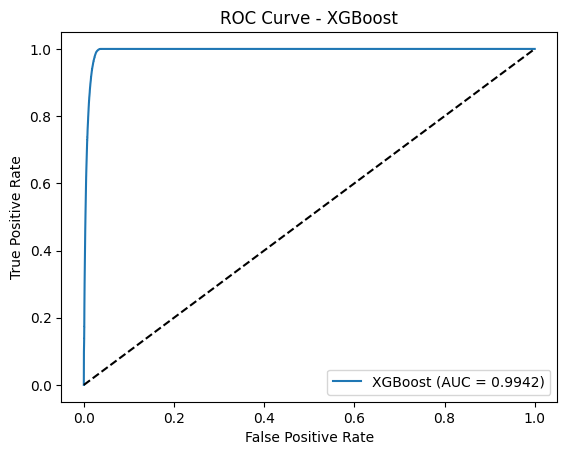

In [7]:
if __name__ == "__main__":
    
    #here just replace your path for test datsets
    
    input_path = r"Test_20\X_Test_Data_Input.csv"
    target_path = r"Test_20\Y_Test_Data_Target.csv"
    
    
    test_input = pd.read_csv(input_path)
    test_target = pd.read_csv(target_path)
    
    test_data = pd.concat([test_input, test_target["target"]], axis=1)
    
    # if you need ppredicted values
    predicted_values = main(test_data)